In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import bnlearn as bn
import seaborn as sns

## Read Data
https://github.com/vidhi-am/tds_articles/blob/master/pgmpy_WICDS/german_credit.csv

In [2]:
df = pd.read_csv('german_credit.csv')

In [3]:
df

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,67,male,2,own,NaN,1169,6,radio/TV,good
1,2,22,female,2,own,little,5951,48,radio/TV,bad
2,4,49,male,1,own,little,2096,12,education,good
3,2,45,male,2,free,little,7882,42,furniture/equipment,good
4,3,53,male,2,free,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,2,31,female,1,own,little,1736,12,furniture/equipment,good
996,2,40,male,3,own,little,3857,30,car,good
997,2,38,male,2,own,little,804,12,radio/TV,good
998,2,23,male,2,free,little,1845,45,radio/TV,bad


In [4]:
df.dtypes

Credit History      int64
Age                 int64
Gender             object
Job                 int64
Housing            object
Saving accounts    object
Credit amount       int64
Duration            int64
Purpose            object
Risk               object
dtype: object

In [5]:
df.describe()

,Credit History,Age,Job,Credit amount,Duration
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.54500,35.546000,1.904000,3271.258000,20.903000
std,1.08312,11.375469,0.653614,2822.736876,12.058814
min,0.00000,19.000000,0.000000,250.000000,4.000000
25%,2.00000,27.000000,2.000000,1365.500000,12.000000
50%,2.00000,33.000000,2.000000,2319.500000,18.000000
75%,4.00000,42.000000,2.000000,3972.250000,24.000000
max,4.00000,75.000000,3.000000,18424.000000,72.000000


In [6]:
df.isna().sum()

Credit History       0
Age                  0
Gender               0
Job                  0
Housing              0
Saving accounts    183
Credit amount        0
Duration             0
Purpose              0
Risk                 0
dtype: int64

In [7]:
# fillna for savings account with 'None'
df['Saving accounts'] = df['Saving accounts'].fillna('No Saving Account')

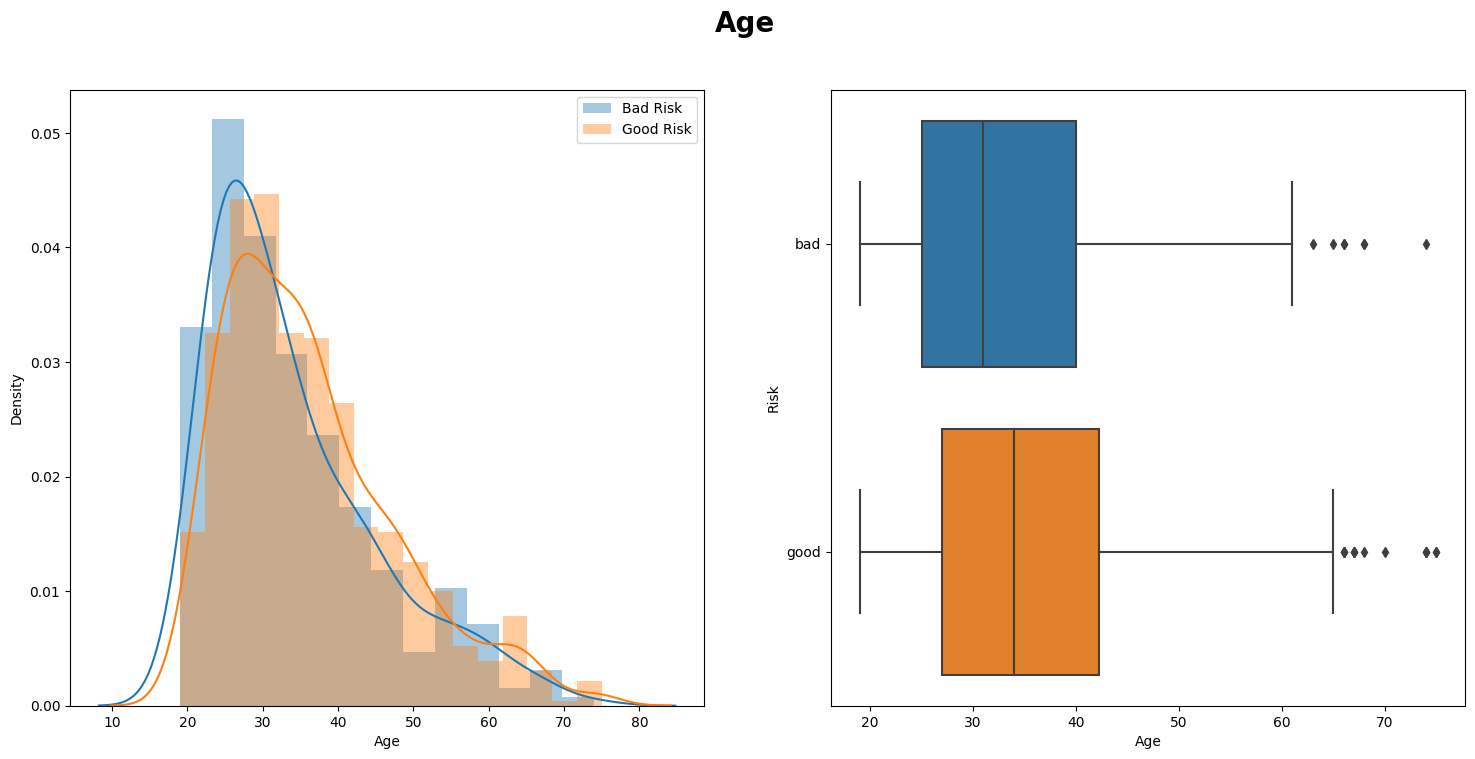

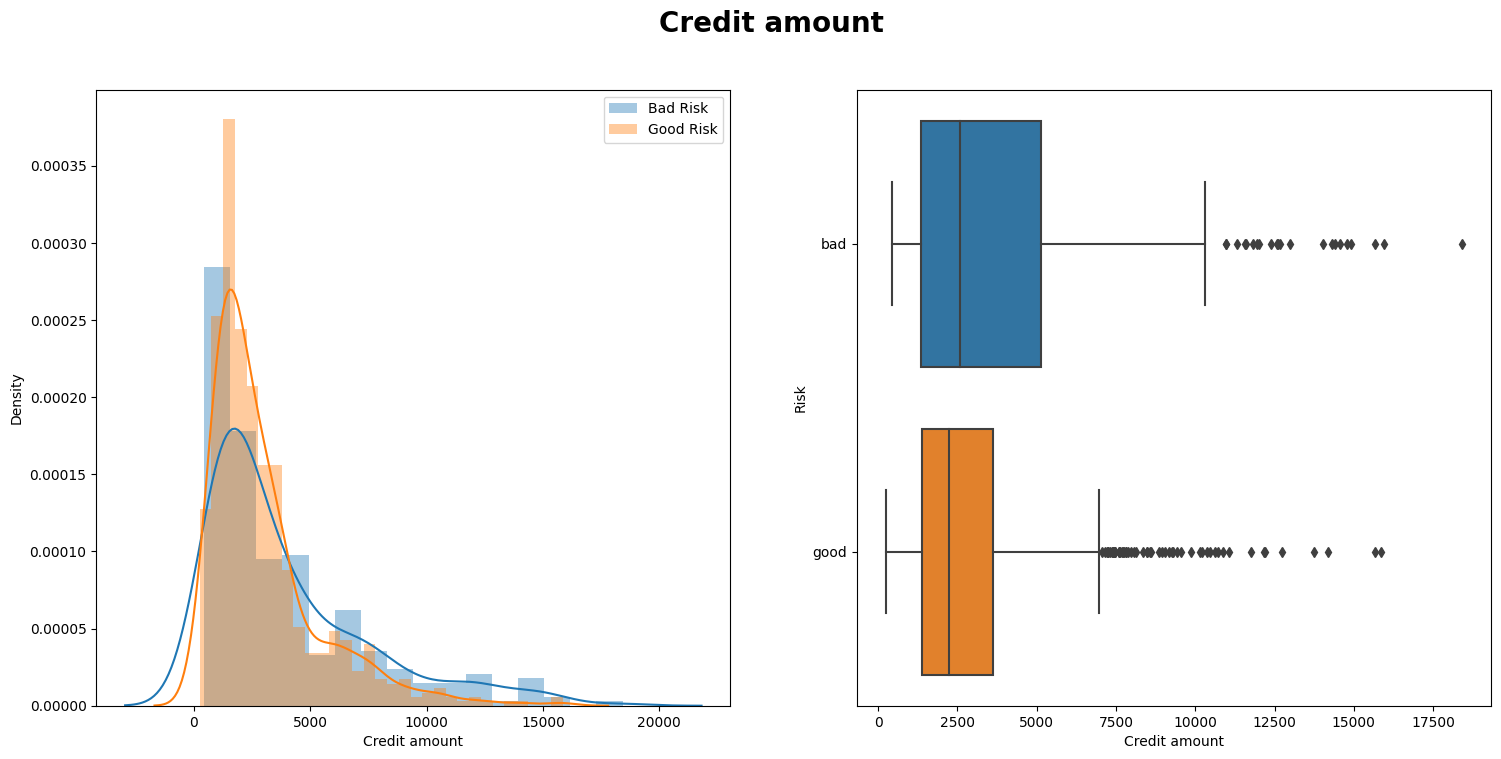

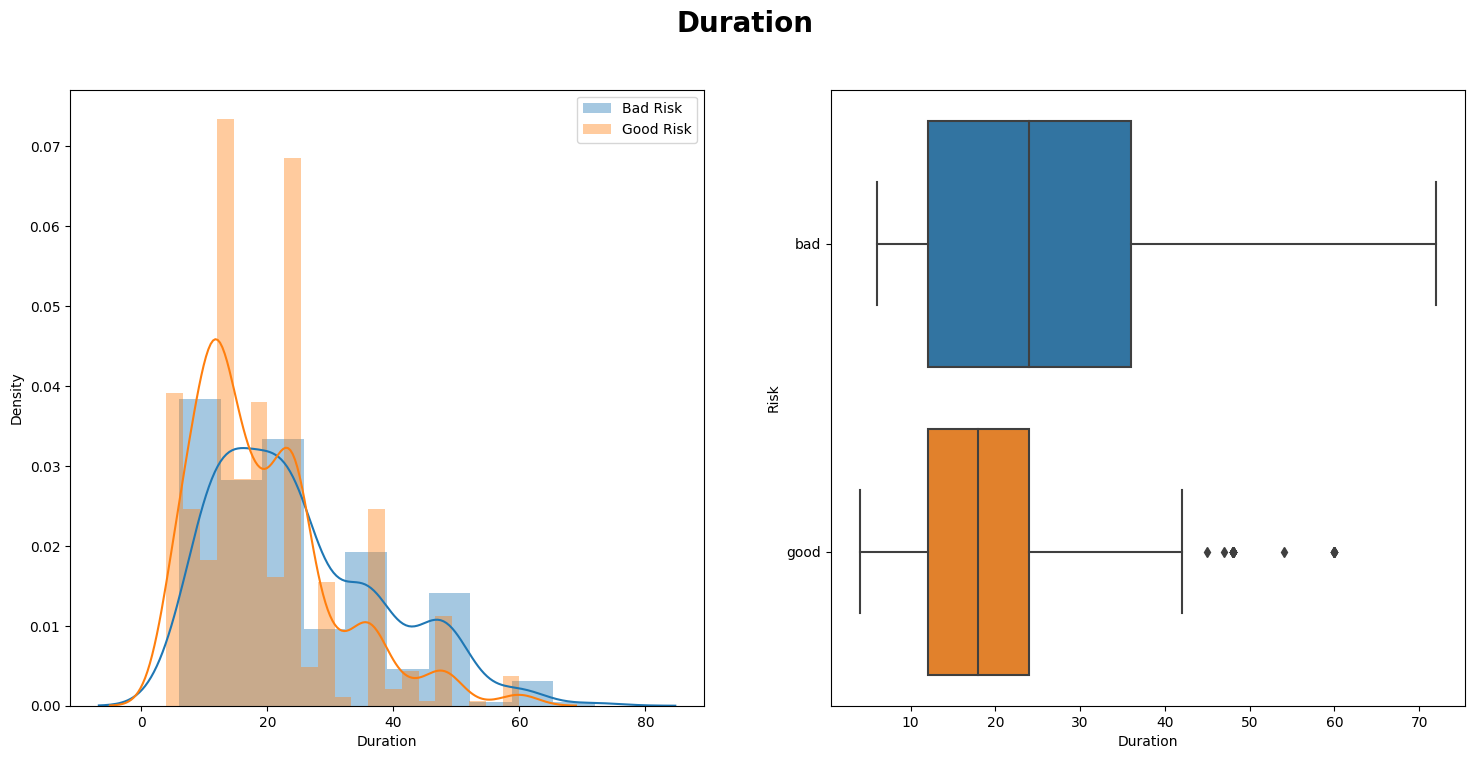

In [8]:
# continuous variables
continuous = ['Age', 'Credit amount', 'Duration']
for col in continuous:
    plt.figure(figsize = (18, 8))
    plt.suptitle(col, size = 20, fontweight = 'bold')
    plt.subplot(1,2,1)
    sns.distplot(df[df['Risk']=='bad'][col], label = 'Bad Risk')
    sns.distplot(df[df['Risk']=='good'][col], label = 'Good Risk')
    plt.legend()
    plt.subplot(1,2,2)
    sns.boxplot(x= col,y = 'Risk', data = df, order = ['bad', 'good'])
    plt.show()

Discretize the continuous variables for bayesian modeling

In [9]:
df['Discretized Credit Amount'] = pd.qcut(df['Credit amount'], q = 3)
df['Discretized Duration'] = pd.qcut(df['Duration'], q = 3)
df['Discretized Age'] = pd.cut(df['Age'], bins = [18,25, 40, df.Age.max()])
df = df.drop(['Credit amount', 'Duration', 'Age'],axis = 1)

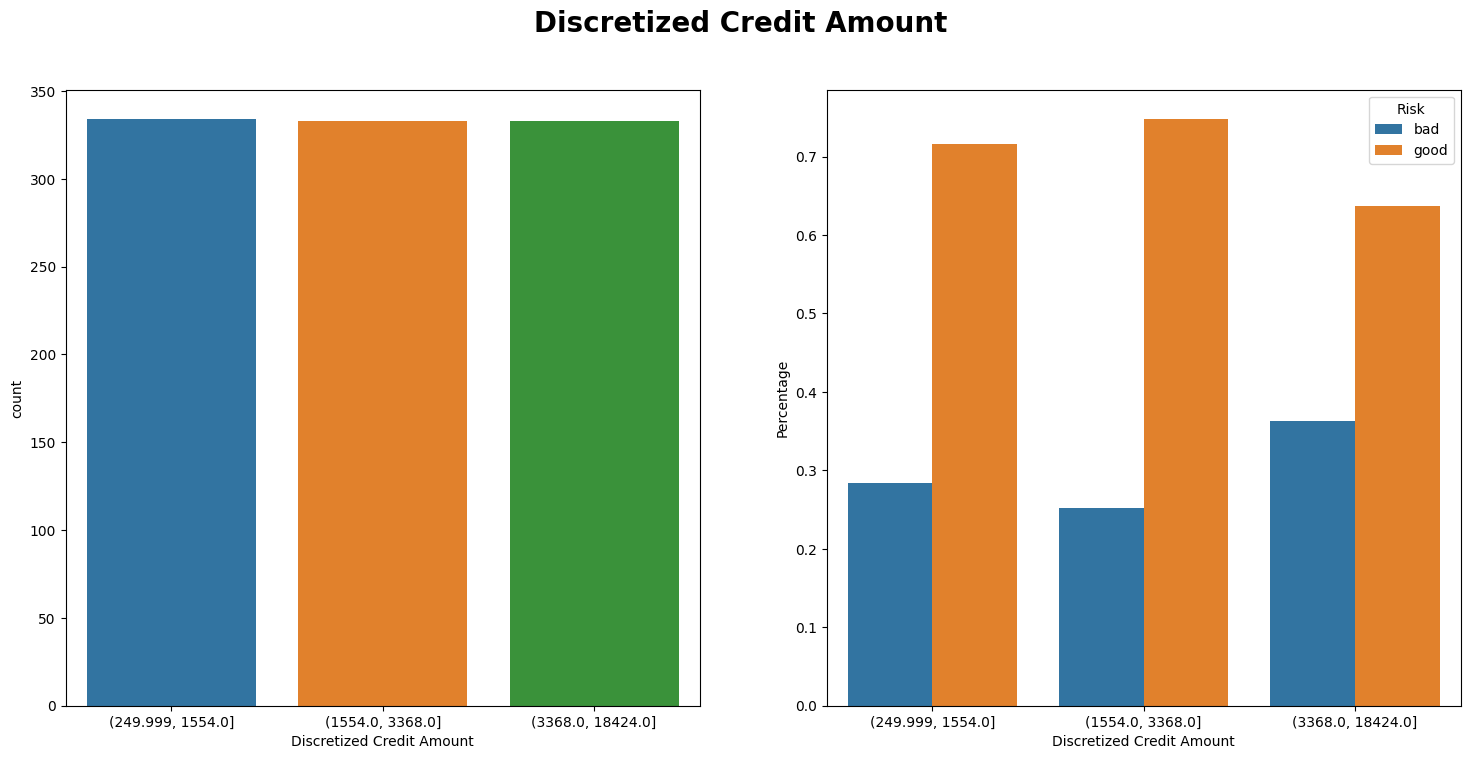

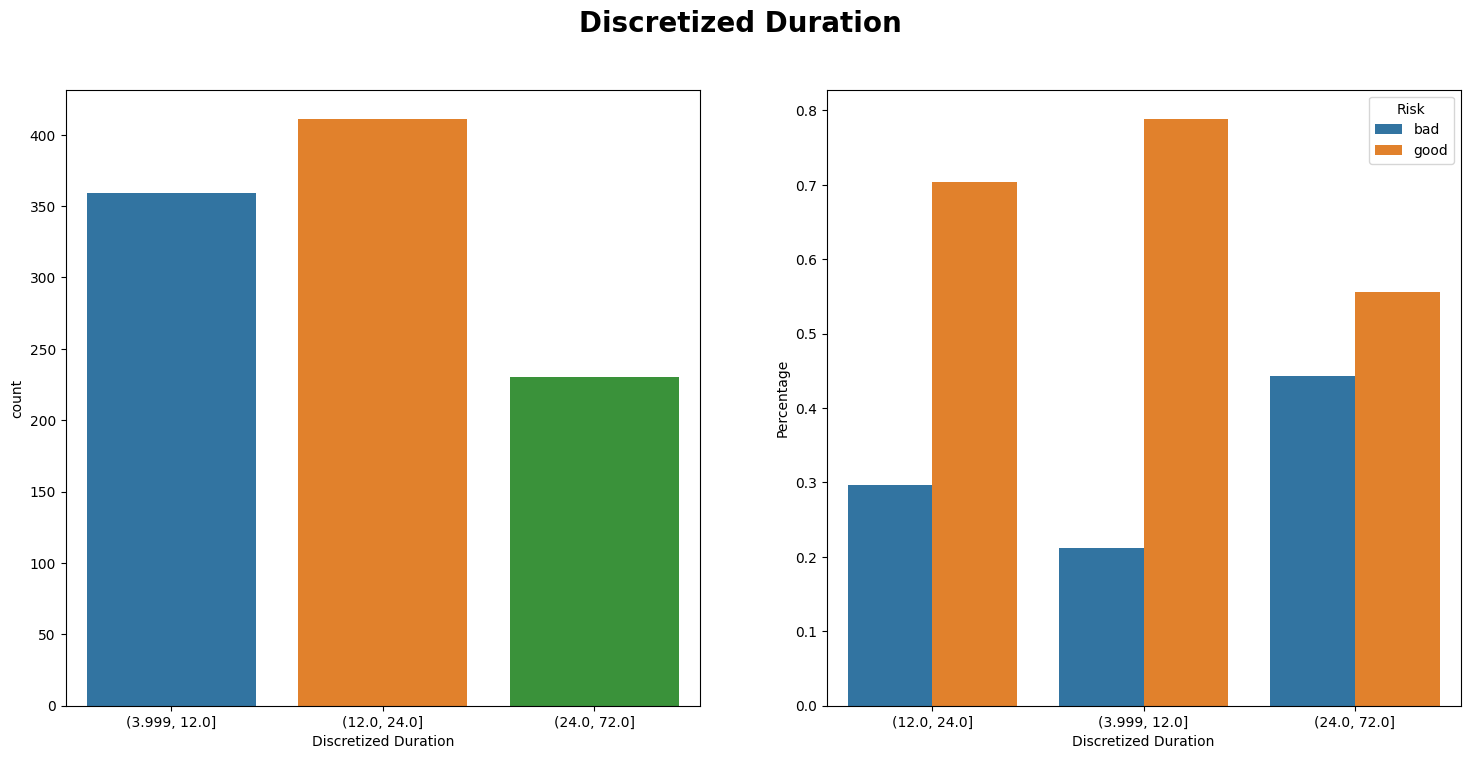

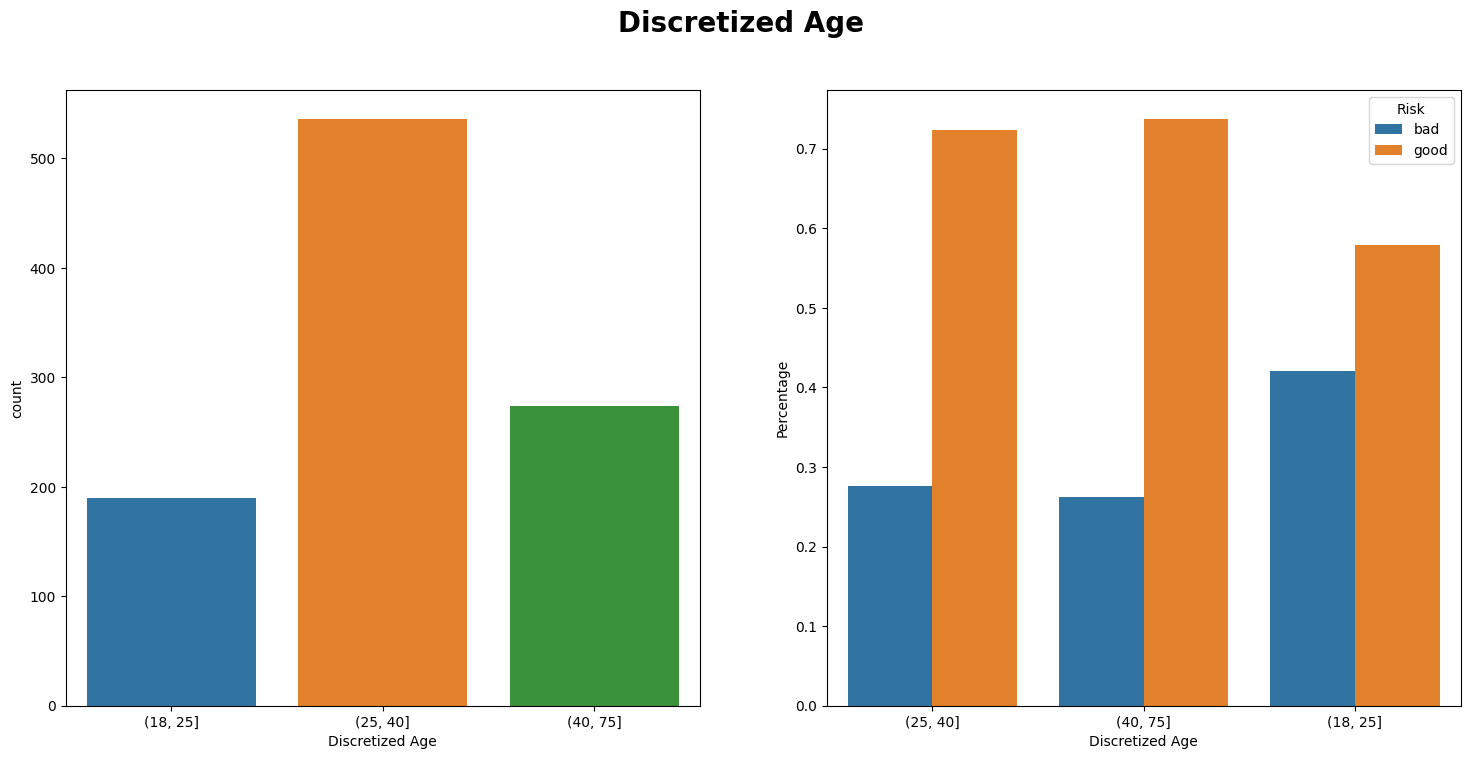

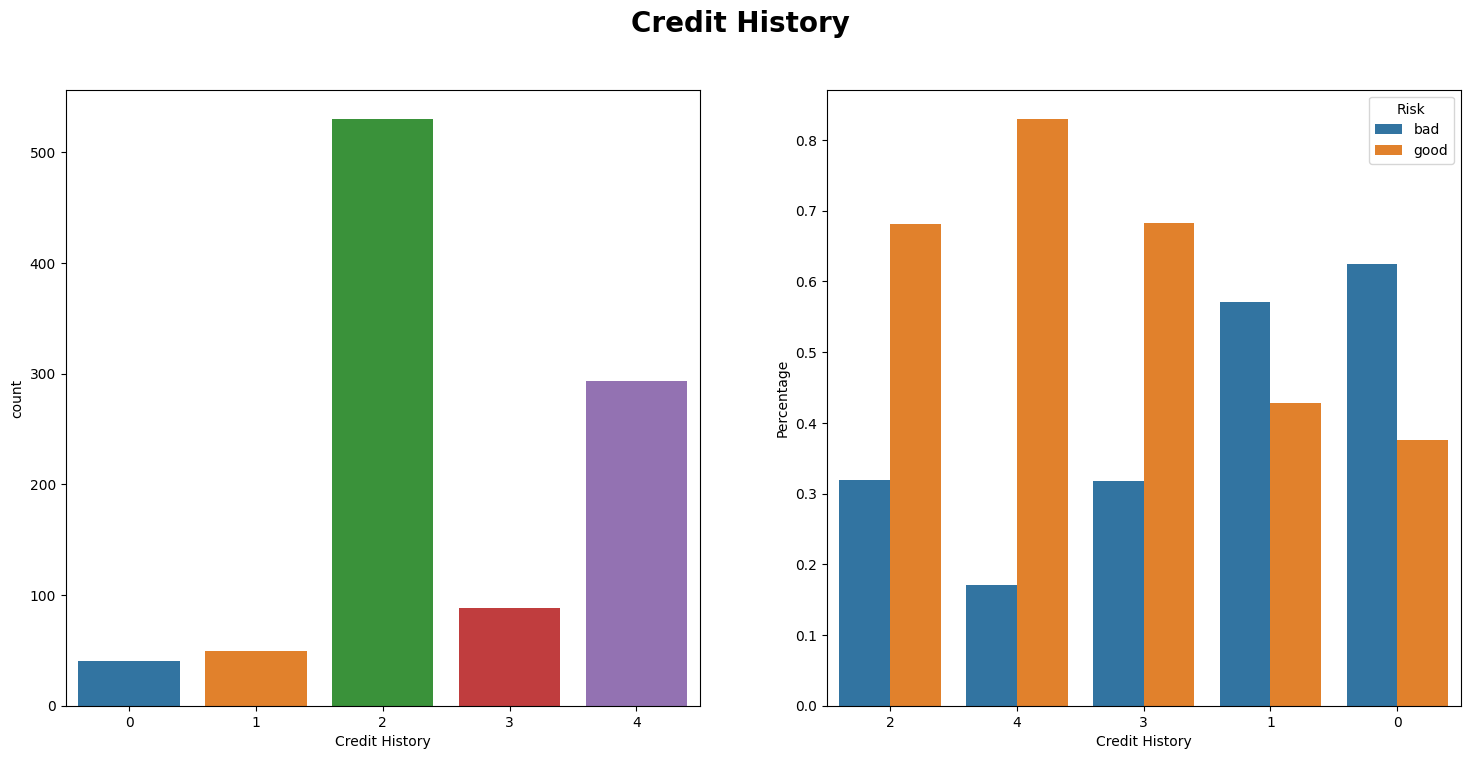

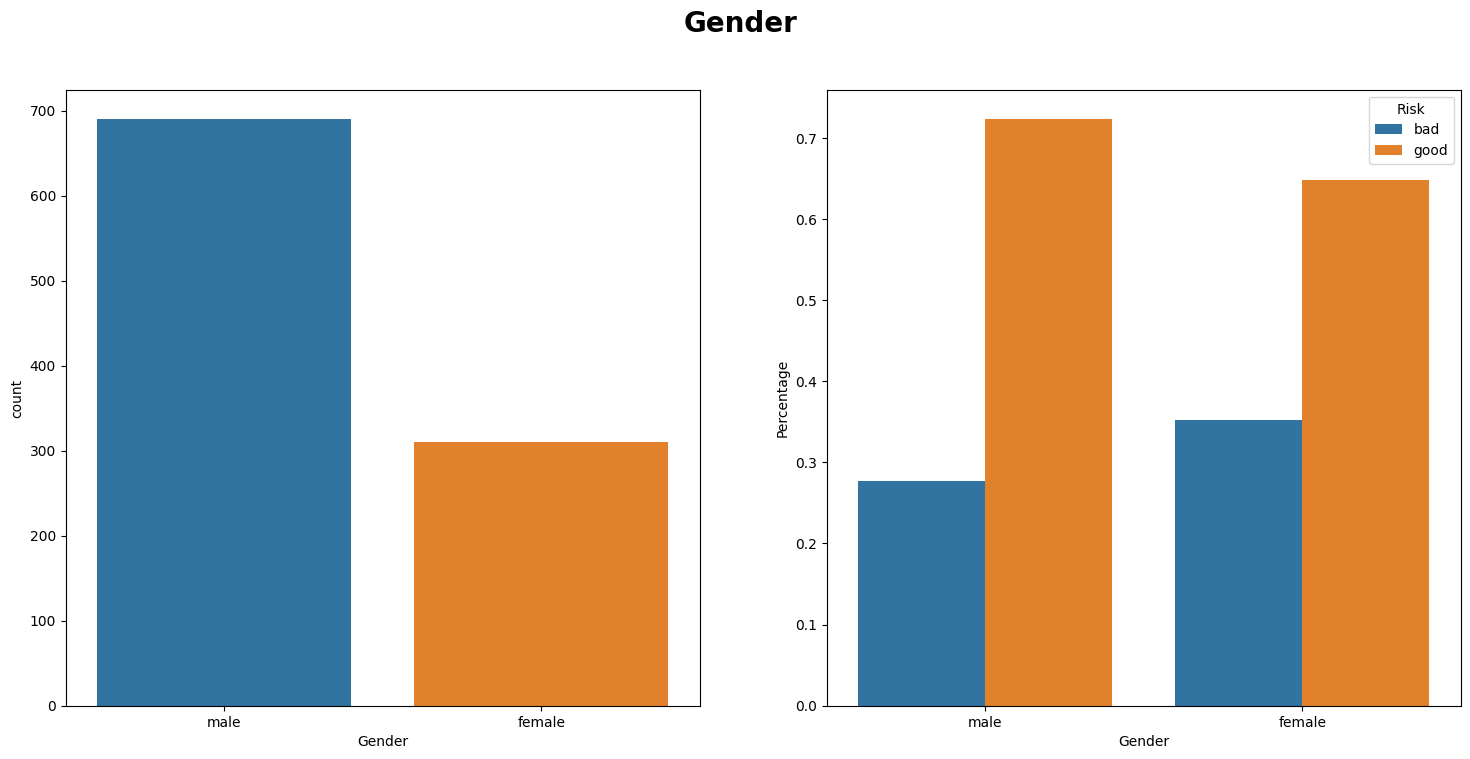

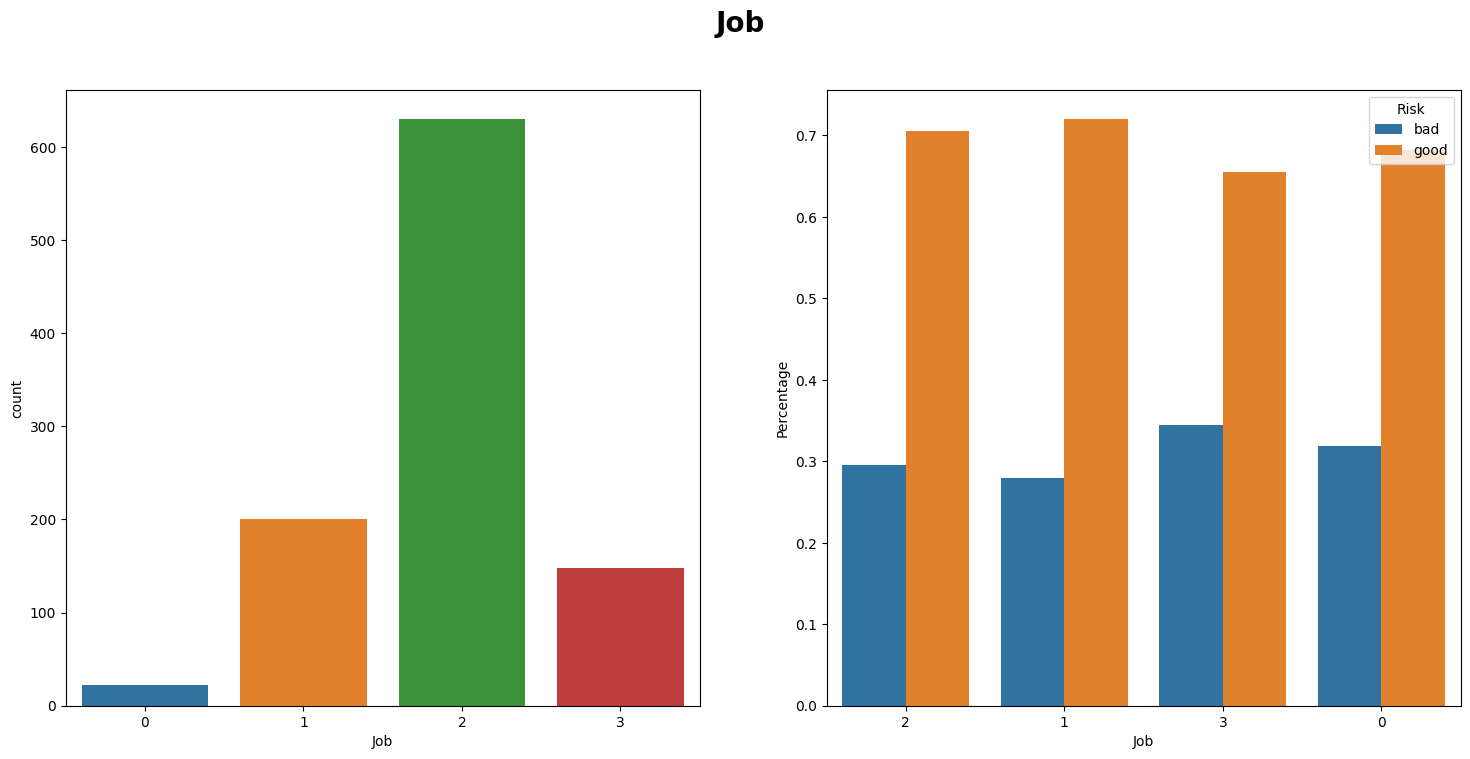

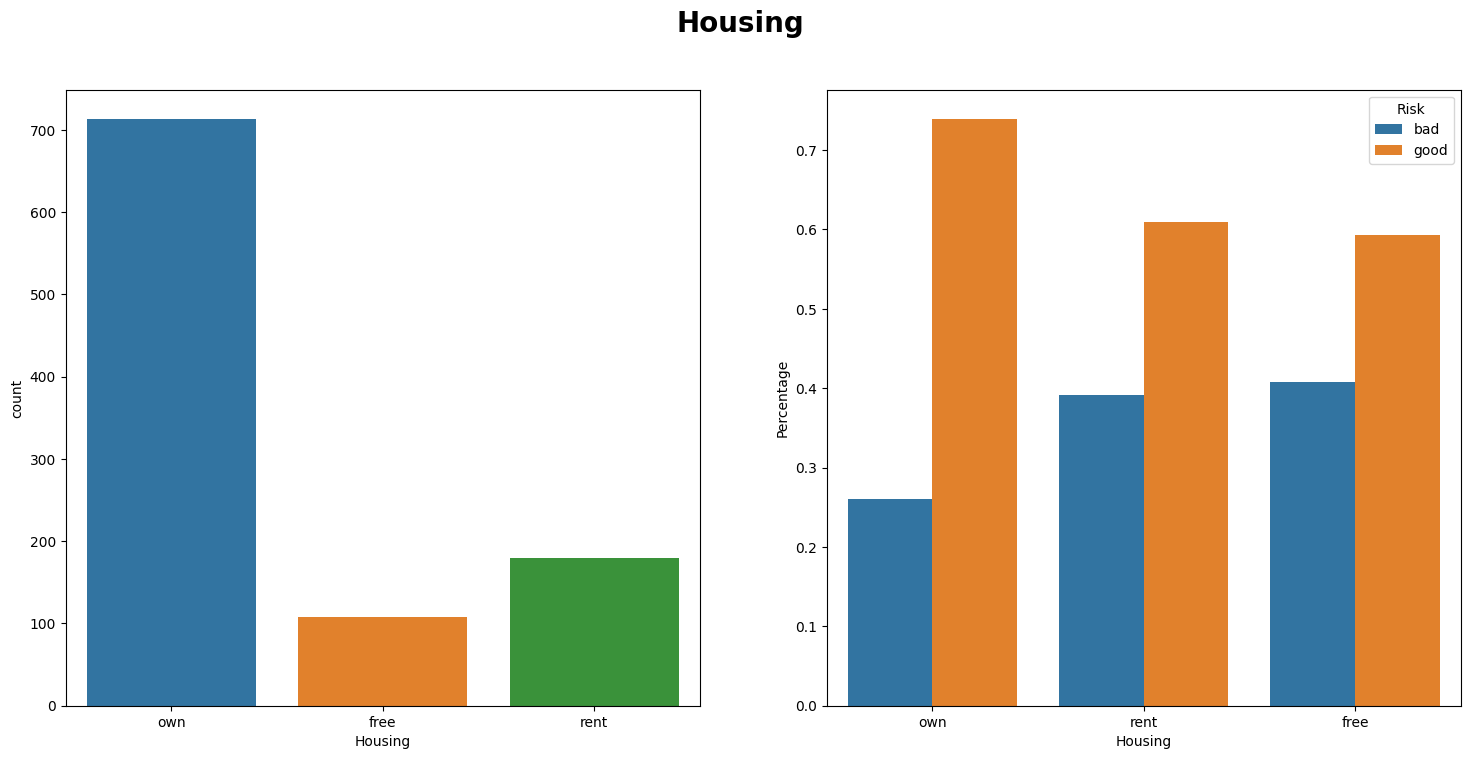

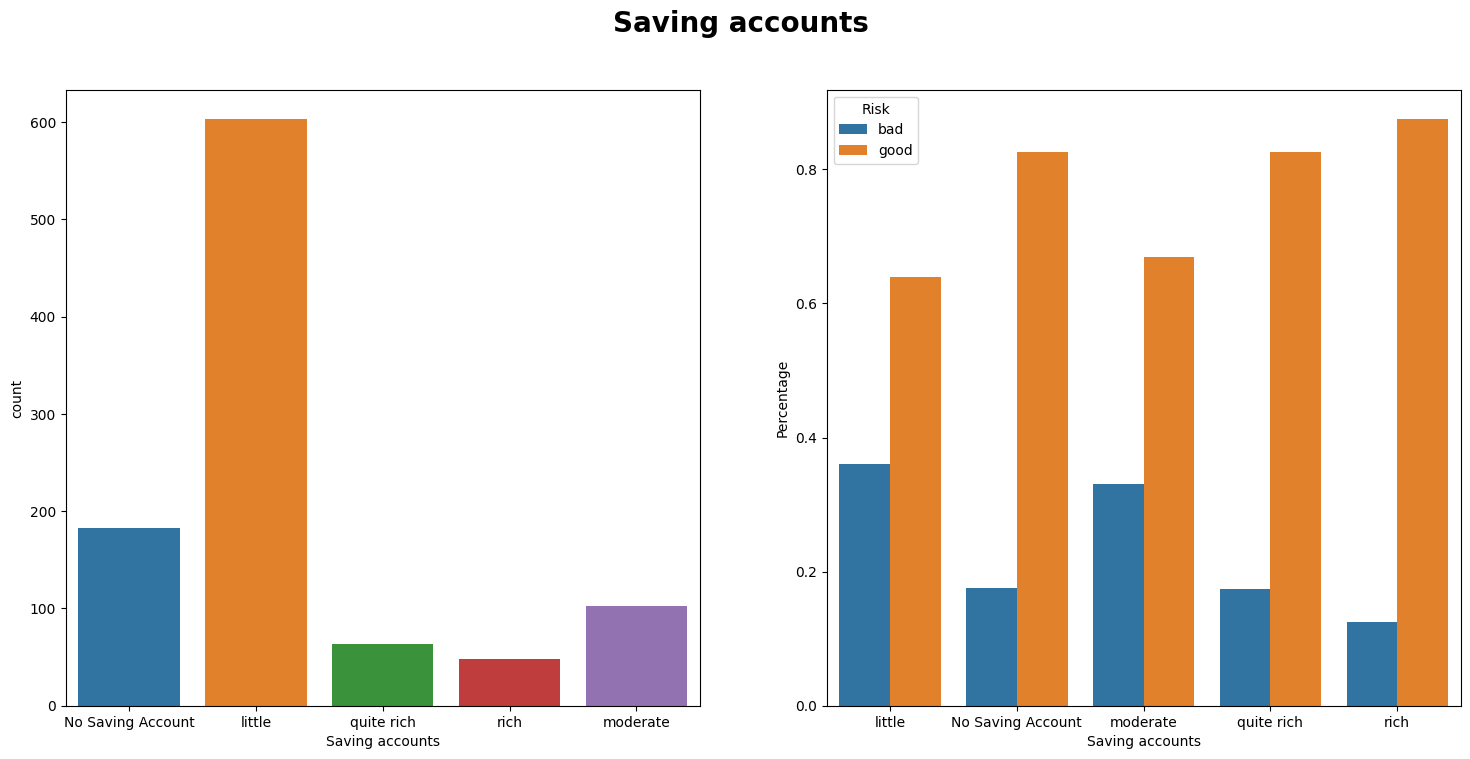

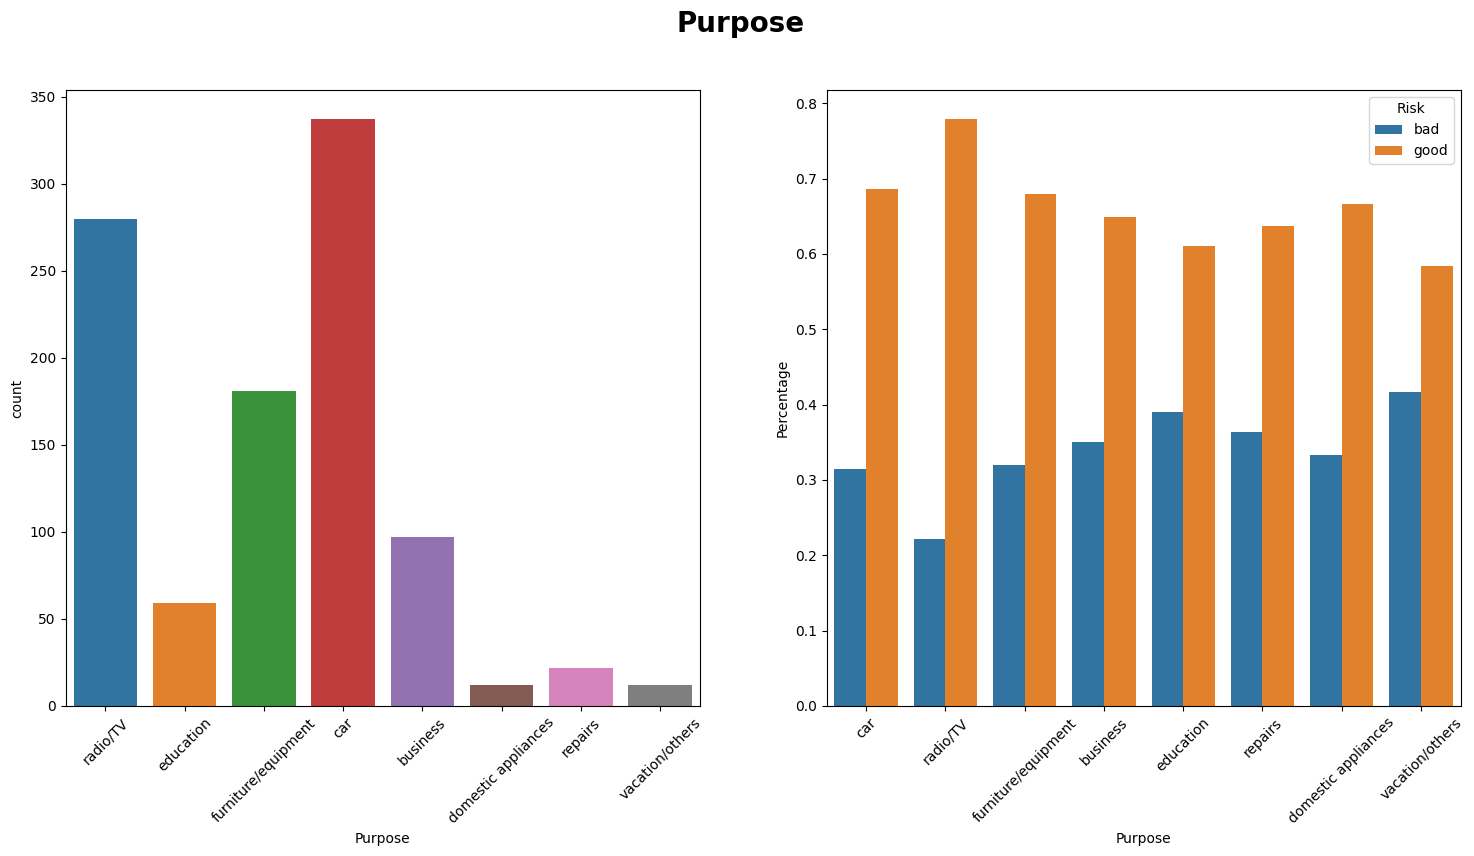

In [10]:
# other columns
columns = ['Discretized Credit Amount','Discretized Duration',  'Discretized Age',
           'Credit History', 'Gender', 'Job', 'Housing', 'Saving accounts', 'Purpose']
for col in columns:
    plt.figure(figsize = (18, 8))
    plt.suptitle(col, size = 20, fontweight = 'bold')
    plt.subplot(1,2,1)
    sns.countplot(x = col, data = df)
    plt.xticks(rotation = 45) if col == 'Purpose' else None
    plt.subplot(1,2,2)
    percentage_groupby = df.groupby(['Risk',col])[col].count() / df.groupby([col])[col].count()
    percentage_df = pd.DataFrame(percentage_groupby).rename({col:'Percentage'}, axis = 1).reset_index()
    sns.barplot(x= col, y = 'Percentage', data = percentage_df, hue = 'Risk', order = df[col].value_counts().index)
    plt.xticks(rotation = 45) if col == 'Purpose' else None
    plt.show()

### Bayesian Modeling
Part 1: Learn the model structure

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


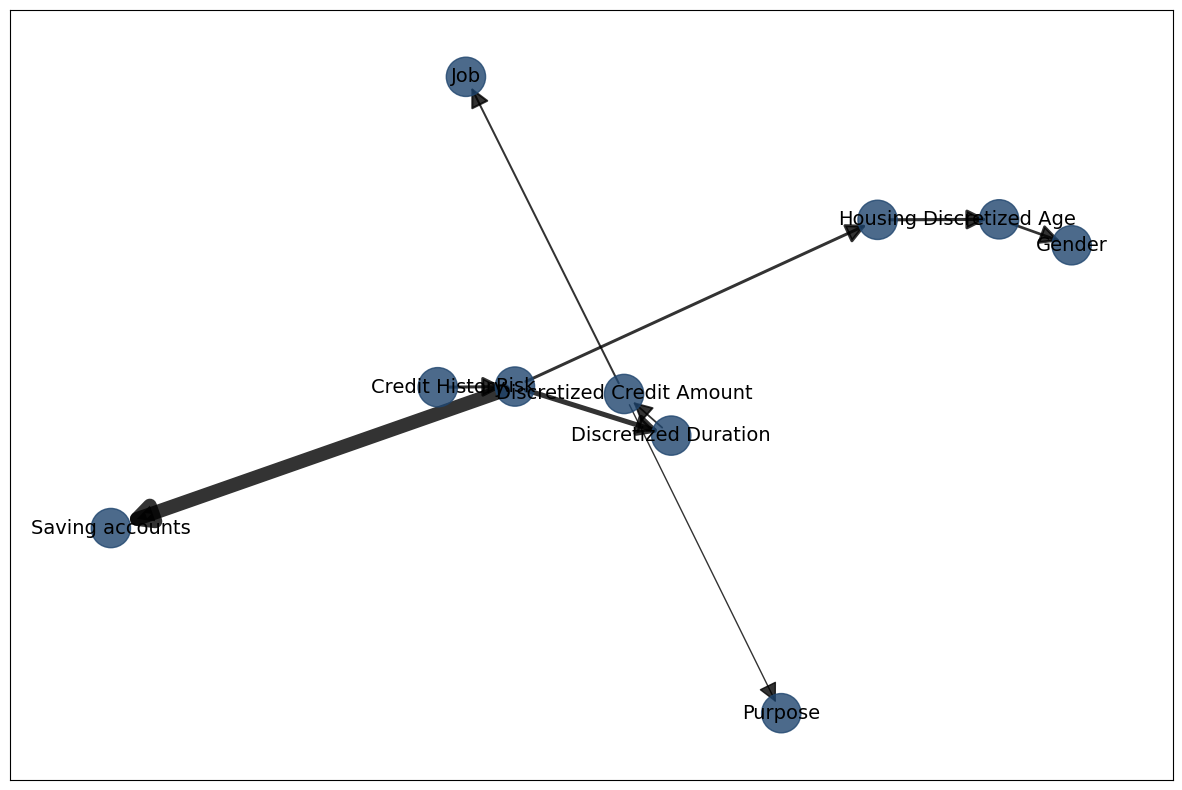

In [11]:
# Learn the structure
model = bn.structure_learning.fit(df, methodtype='hc', scoretype='bic')

# Independence test
model = bn.independence_test(model, df, prune=True)
# [bnlearn] >Compute edge strength with [chi_square]

# Make plot
bn.plot(model)
plt.show()
# Create interactive plot
# bn.plot(model, interactive=True)

Part 2: Hardcode the model DAG

[bnlearn] >bayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


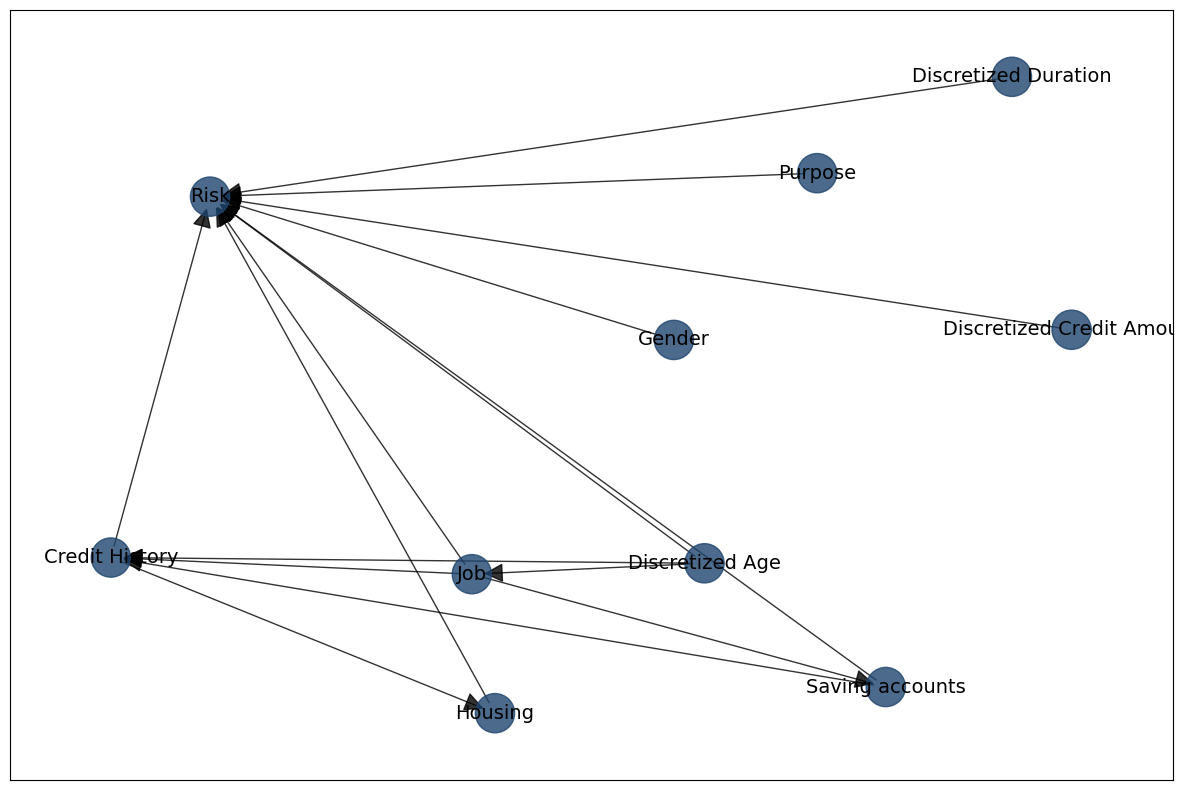

In [12]:
edges = [('Credit History', 'Risk'),
         ('Gender', 'Risk'),
         ('Job', 'Risk'),
         ('Housing', 'Risk'),
         ('Saving accounts', 'Risk'),
         ('Purpose', 'Risk'),
         ('Discretized Credit Amount', 'Risk'),
         ('Discretized Duration', 'Risk'),
         ('Discretized Age', 'Risk'),
         
         ('Credit History', 'Housing'),
         ('Saving accounts', 'Credit History'),
         ('Job','Saving accounts'),
         ('Job','Credit History'),
         ('Discretized Age','Job'),
         ('Discretized Age','Credit History'),
         
        ]

# Create DAG based on edges
DAG = bn.make_DAG(edges)
bn.plot(DAG)
plt.show()

In [13]:
# Fit model based on DAG and discretized continous columns
model = bn.parameter_learning.fit(DAG, df)

# Use MLE method
# model_mle = bn.parameter_learning.fit(DAG, df_discrete, methodtype="maximumlikelihood")

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of Credit History:
+-------------------+-----+---------------------------+
| Discretized Age   | ... | Discretized Age((40, 75]) |
+-------------------+-----+---------------------------+
| Job               | ... | Job(3)                    |
+-------------------+-----+---------------------------+
| Saving accounts   | ... | Saving accounts(rich)     |
+-------------------+-----+---------------------------+
| Credit History(0) | ... | 0.17857142857142858       |
+-------------------+-----+---------------------------+
| Credit History(1) | ... | 0.17857142857142858       |
+-------------------+-----+---------------------------+
| Credit History(2) | ... | 0.23214285714285715       |
+-------------------+-----+---------------------------+
| Credit History(3) | ... | 0.17857142857142858       |
+-------------------+-----+---------------------------+
| Credit History(4) | ... | 0.23214285714285715       |
+---

[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >Edge [Credit History <-> Housing] [P=0.01528] is excluded because it was not significant (P<0.01) with [chi_square]
[bnlearn] >Edge [Gender <-> Risk] [P=0.0207399] is excluded because it was not significant (P<0.01) with [chi_square]
[bnlearn] >Edge [Job <-> Risk] [P=0.596582] is excluded because it was not significant (P<0.01) with [chi_square]
[bnlearn] >Edge [Job <-> Saving accounts] [P=0.35101] is excluded because it was not significant (P<0.01) with [chi_square]
[bnlearn] >Edge [Job <-> Credit History] [P=0.39745] is excluded because it was not significant (P<0.01) with [chi_square]
[bnlearn] >Edge [Saving accounts <-> Credit History] [P=0.20045] is excluded because it was not significant (P<0.01) with [chi_square]
[bnlearn] >Edge [Purpose <-> Risk] [P=0.0579259] is excluded because it was not significant (P<0.01) with [chi_square]
[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] tes

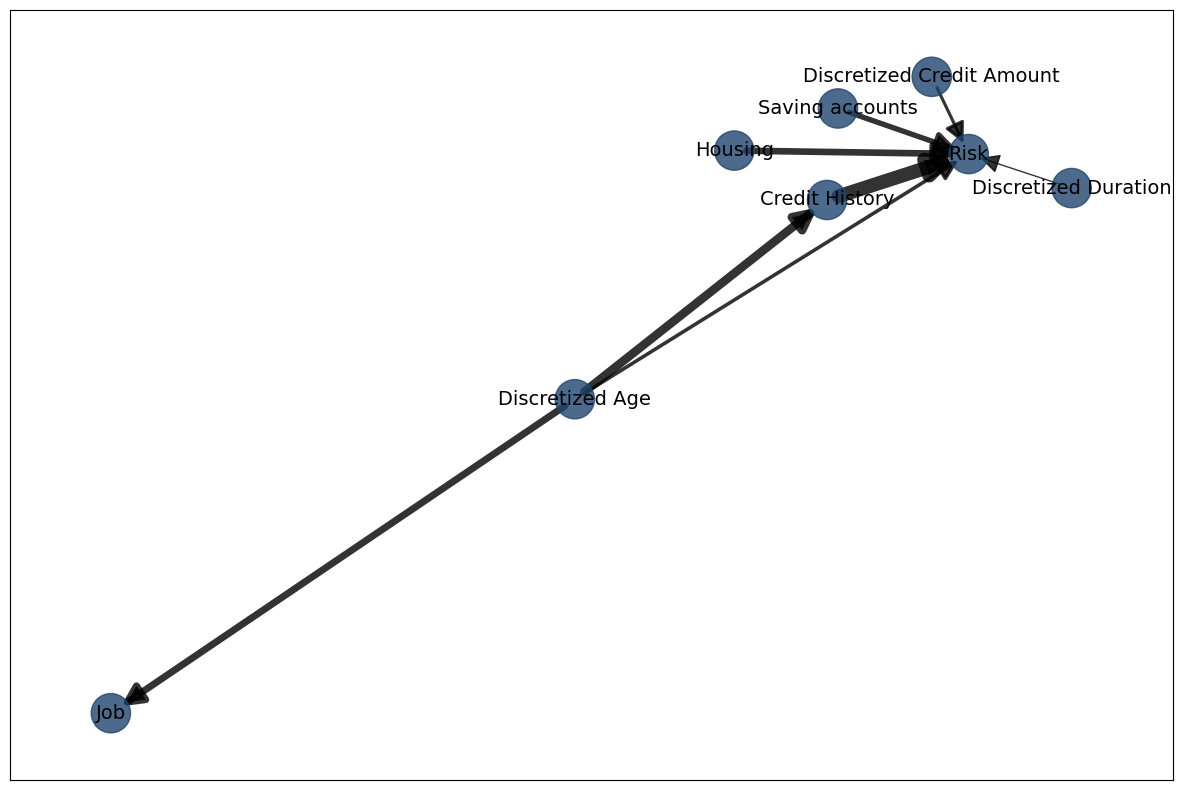

In [14]:
model = bn.independence_test(model, df, prune=True, alpha=.01)
bn.plot(model)
plt.show()

### Draw Inference

In [15]:
condition = "Discretized Age"
evidence = {condition: bn.discretize_value(df[condition], 20
                                         )}
print(evidence)
# {'weight': Interval(2959.5, 3657.5, closed='right')}

print(bn.inference.fit(model, variables=["Risk"], evidence=evidence, verbose=0))

{'Discretized Age': Interval(18, 25, closed='right')}
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.4978 |
+------------+-------------+
| Risk(good) |      0.5022 |
+------------+-------------+


In [16]:
bn.inference.fit(model, variables=['Risk'], evidence={'Saving accounts':'little',
                                                      condition: bn.discretize_value(df[condition], 20),
                                                      'Credit History': 0})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+--------+----------+
|    | Risk   |        p |
+====+========+==========+
|  0 | bad    | 0.502228 |
+----+--------+----------+
|  1 | good   | 0.497772 |
+----+--------+----------+


<DiscreteFactor representing phi(Risk:2) at 0x292ee6390>